# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

Dead loop detection.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [199]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 20000
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

In [200]:
G = generate_low_degree_g(num_nodes=1000)
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

4
2
1000
1759


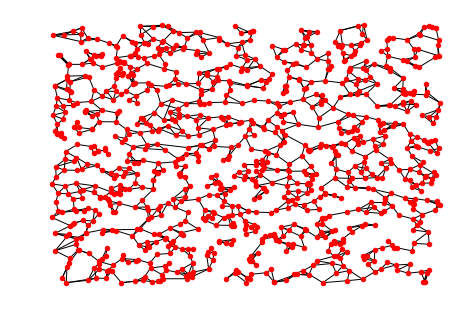

In [202]:
plot_g(G, with_labels=False, node_size=20, font_size=4)

In [284]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # TODO: allow look backwards
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, sample_size_lower_bound=500, frequent=100):
    
    X = []
    y = []
    
    pair_path_dict = dict()
    
    selected_pairs = []
    sample_cnt = 0
    num_of_nodes = G.number_of_nodes()
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        selected_pairs.append((src, dst))
        
        for src, dst in [(src, dst), (dst, src)]:
            try:
                path = nx.dijkstra_path(G, src, dst)
                # TODO record all paths for later use
                
            except NetworkXNoPath:
                print("No path between %d and %d" % (src, dst))
                break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                X.append(encode_edges(G, parent_node, cur_node, src, dst))
                y.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
                sample_cnt += 1
                
                if sample_cnt % frequent == 0:
                    print("Collected %d samples." % (sample_cnt))
        
        if sample_cnt >= sample_size_lower_bound:
            break
        
    return X, y, selected_pairs, pair_path_dict

In [ ]:
features, labels, selected_pairs, pair_path_dict = generate_stochastic_dataset(G, \
                                                               sample_size_lower_bound=500000, \
                                                               frequent=30000)
print("%d pairs are selected" % (len(selected_pairs)))

In [205]:
print(len(labels))
print(len(selected_pairs))
print(len(pair_path_dict))

500038
8557
16090


In [207]:
pair_path_len_dict = map(lambda d: (d[0], len(d[1])), pair_path_dict.items())
max_selected_path_len = max(pair_path_len_dict, key=lambda d:d[1])
min_selected_path_len = min(pair_path_len_dict, key=lambda d:d[1])

print max_selected_path_len
print min_selected_path_len

((193, 119), 81)
((510, 839), 2)


In [208]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def one_hot_encode(idx, length=max_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
            if cnt % print_freq == 0:
                print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [215]:
X, y = augment_dataset(features, labels,\
                       augmentation_index=16, \
                       print_freq=600000)
print(X.shape)
print(y.shape)

Processed 600000 samples
Processed 1200000 samples
Processed 1800000 samples
Processed 2400000 samples
Processed 3000000 samples
Processed 3600000 samples
Processed 4200000 samples
Processed 4800000 samples
Processed 5400000 samples
Processed 6000000 samples
Processed 6600000 samples
Processed 7200000 samples
Processed 7800000 samples
(8000608, 28)
(8000608,)


In [216]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6800516, 28)
(6800516,)
(1200092, 28)
(1200092,)


In [217]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [218]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=1024)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=512)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [219]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 5000),
              epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=10) 

In [227]:
# acc = mx.metric.Accuracy()
# train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)
# model.score(train_iter, acc)
# print('Acc on training set %f' % acc.get()[1])

# acc = mx.metric.Accuracy()
# test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
# model.score(test_iter, acc)
# print('Acc on test set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
all_iter = mx.io.NDArrayIter(X, y, batch_size=batch_size)
model.score(all_iter, acc)
print('Acc on all %f' % acc.get()[1])

Acc on all 0.957148


In [268]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
    
#     if neighbor in path:
#         print("Duplicated nodes, randomizing next node")
#         avaliable_neighbors = filter(lambda d: d >= 0 and d != neighbor, input_vec[:, -1])

#         if len(avaliable_neighbors) == 0:
#             print("Duplicated nodes, no other nodes available")
#         else:
#             neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None, invalid_path_threshold=100):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, path, parent_node, cur_node, src, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [295]:
# G = generate_low_degree_g()
def calc_statistics(G, pair_path_dict, num_to_test=100):
    found_cnt = 0
    opt_path_cnt = 0
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))

    def heuristic(node, dst):

        x_src = G.nodes[src]['x']
        y_src = G.nodes[src]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        x_node = G.nodes[node]['x']
        y_node = G.nodes[node]['y']

        dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
        dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
        ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

        return ret
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
            print("The model is unable to find a path between %d and %d" % (src, dst))
            print("Dijkstra path :", dijkstra_path)
            print("NN path :", nn_path)
            print('')
            continue

        found_cnt += 1
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            pass
# #             astar_path = nx.astar_path(G, src, dst, heuristic=heuristic)
#             print('Printing all paths for reference:')
#             print("Dijkstra path :", dijkstra_path)
# #             print("A star path :", astar_path)
#             print("NN path :", nn_path)
#             print('')

    return found_cnt, opt_path_cnt

In [296]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, pair_path_dict=pair_path_dict, num_to_test=num_to_test)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))

In [ ]:
print_paths_statistics(G, num_to_test=100, pair_path_dict=pair_path_dict)

# 9893 out of 9900 can find path: 0.999293
# 8803 out of 9893 can find optimal path: 0.889821
# 8803 out of 9900 all paths can find optimal paths: 0.889192

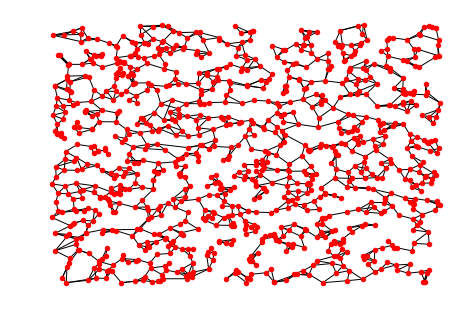

In [248]:
plot_g(G, with_labels=False, node_size=20, font_size=8)

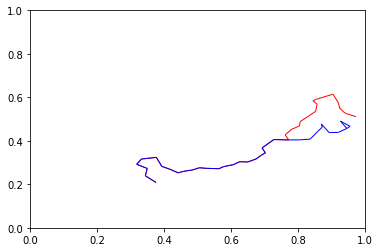

In [322]:
dijkstra_node_list = [719, 775, 797, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 391, 384, 338, 168, 515, 334, 372, 354, 965, 856, 167, 606, 943, 782, 576]
nn_node_list =       [719, 775, 797, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 438, 66, 819, 459, 640, 850, 269, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687, 425, 604, 687]
pos = {}

for node in dijkstra_node_list:
    pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

dijkstra_edge_list = []
for idx, node in enumerate(dijkstra_node_list[:-1]):
    dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')

nn_pos = {}

for node in nn_node_list:
    nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

nn_edge_list = []
for idx, node in enumerate(nn_node_list[:-1]):
    nn_edge_list.append((node, nn_node_list[idx+1]))

nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')